# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Importing all the necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from functools import reduce
import time

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


## Loading the dataset


In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries ie the diemnsion of the data is 1460 by 81 including the 'ID'. We can see all 81 dimensions of our dataset by printing out the few  entries using the following code:

In [4]:
dataset_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column since it is not important for model training and reducing the dimension to 1460 by 80.

In [5]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


checkingt the types of feature columns using the python built in command called info() 

In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

From the output of the code, some features are having missing values that needs to be clean but we hold it for now.

## Checking The  Distribution of House Prices

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


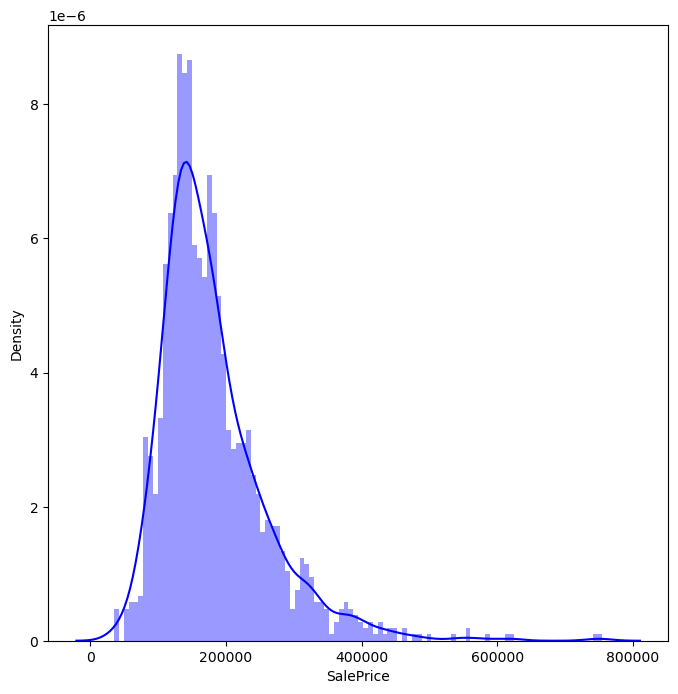

In [7]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(8, 8))
sns.distplot(dataset_df['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4});

The distribution graph shows that the prices of houses are positively/ rightly skewed.

## Numerical data distribution
The entire data, consist of both categorical and numerical values so we will divide the data accordingly.
We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [8]:
list(set(dataset_df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

In [9]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

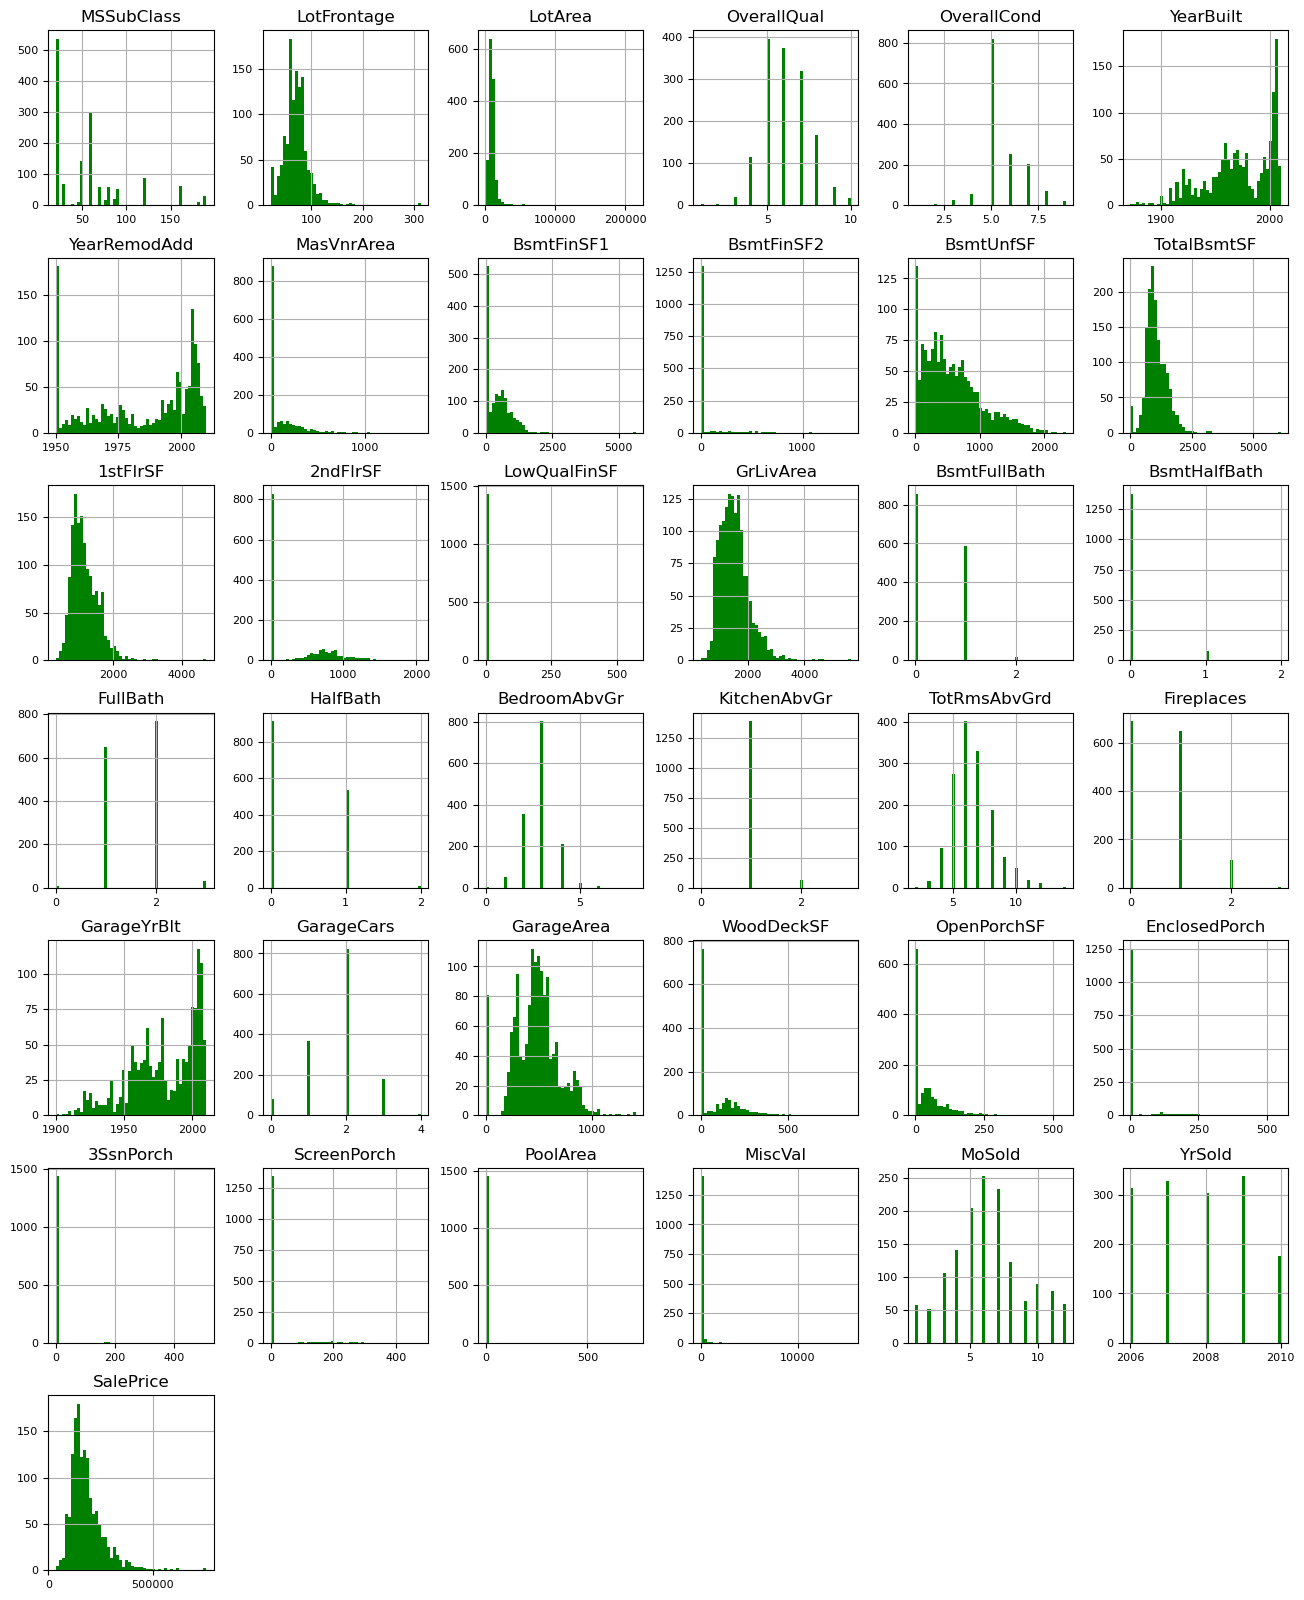

In [10]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color ='g');

## Preparing the dataset

Now on cleaning the dataset. This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [11]:
import numpy as np

def split_dataset(dataset, test_ratio=0.25):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1122 examples in training, 338 examples in testing.


In [12]:
import numpy as np
import pandas as pd

def split_dataset(dataset, test_ratio=0.25, seed=2025):
    """
    Splits a DataFrame into train and test sets with exact proportions.
    
    Parameters:
        dataset (pd.DataFrame): full dataset
        test_ratio (float): fraction of data to use as test
        seed (int): random seed for reproducibility
    
    Returns:
        train_ds, valid_ds (pd.DataFrame, pd.DataFrame)
    """
    np.random.seed(seed)
    # Shuffle indices
    shuffled_indices = np.random.permutation(len(dataset))
    
    # Compute exact test size
    test_size = int(len(dataset) * test_ratio)
    
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    
    train_ds = dataset.iloc[train_indices]
    valid_ds = dataset.iloc[test_indices]
    
    return train_ds, valid_ds

# Example usage
train_ds_pd, valid_ds_pd = split_dataset(dataset_df, test_ratio=0.25)
print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in testing.")


1095 examples in training, 365 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [13]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Selecting a Model

There are several tree-based models for you to choose from.

* Random Forest Model (RF)
* Gradient Boosted Trees Model (GBT)
* Classification ans Regression Tree Model (CART)
* Distributed Gradient Boosted Trees Model (DGBT)

To start, we'll work and compare the following models: a Random Forest,Gradient Boosted Trees, and Classification ans Regression Tree . The Random Forest is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

Gradient Boosted Trees (GBT)

A Gradient Boosted Tree model is a collection of decision trees trained sequentially, where each new tree focuses on correcting the errors of the previous trees. The algorithm is unique in that it achieves high predictive accuracy, can handle both regression and classification tasks, and allows fine control over bias-variance trade-offs through parameters like learning rate and number of trees.

CART (Classification and Regression Tree)

A CART model builds a single decision tree by recursively splitting the data based on feature values to minimize a loss function (Gini impurity for classification, mean squared error for regression). The algorithm is unique in that it is simple to interpret, easy to visualize, and forms the foundation for ensemble methods like Random Forests and Gradient Boosting.

We can list the all the available models in TensorFlow Decision Forests using the following code:

# FIRST RUNNING ONLY RANDOM FOREST

In [14]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [15]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpoenl0a48 as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [16]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.317171. Found 1095 examples.
Training model...


[INFO 2025-09-22T16:59:04.510265805+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoenl0a48/model/ with prefix 13269d78dacc4e6f


Model trained in 0:00:02.342788
Compiling model...


[INFO 2025-09-22T16:59:04.932149335+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 104024 node(s), and 75 input feature(s).
[INFO 2025-09-22T16:59:04.932217033+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2025-09-22T16:59:04.932281434+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Visualizing the R F model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select the  number of tree to display below.

In [17]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=4)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 25% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our Random Forest Model.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

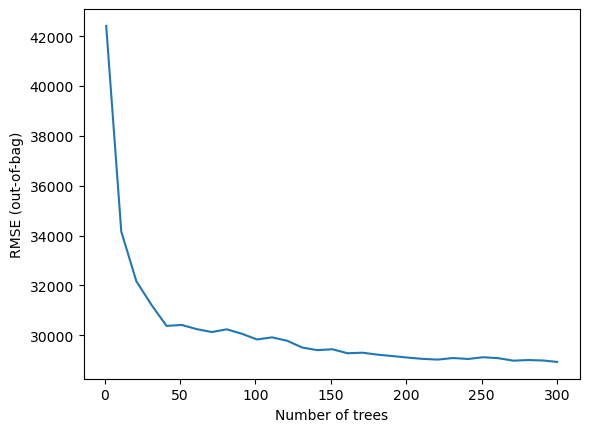

In [18]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [19]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1095, accuracy=None, loss=None, rmse=28933.689510394754, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [20]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 769ms/step - loss: 0.0000e+00 - mse: 996799680.0000
loss: 0.0000
mse: 996799680.0000


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [21]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [22]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 114.0),
 ("ExterQual" (4; #22), 68.0),
 ("Neighborhood" (4; #59), 50.0),
 ("GarageCars" (1; #32), 20.0),
 ("GrLivArea" (1; #38), 20.0),
 ("KitchenQual" (4; #44), 8.0),
 ("YearBuilt" (1; #76), 8.0),
 ("TotalBsmtSF" (1; #73), 4.0),
 ("GarageArea" (1; #31), 3.0),
 ("BsmtQual" (4; #14), 2.0),
 ("GarageFinish" (4; #34), 2.0),
 ("FullBath" (1; #29), 1.0)]

Plot the variable importances from the inspector using Matplotlib

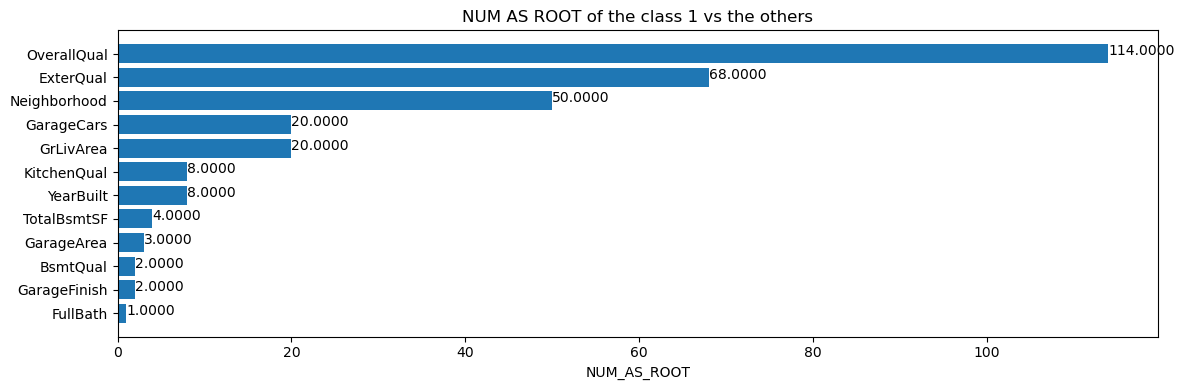

In [23]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [24]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()


2/2 [==============================] - 1s 25ms/step


,Id,SalePrice
0,1461,127086.578125
1,1462,152444.578125
2,1463,180031.156250
3,1464,182889.968750
4,1465,195330.046875


In [25]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 27ms/step


,Id,SalePrice
0,1461,127086.578125
1,1462,152444.578125
2,1463,180031.156250
3,1464,182889.968750
4,1465,195330.046875


# COMBINING THE OTHER TWO MODELS WITH RANDOM FOREST AS ONE


In [26]:
# =============================
# 1. Evaluation Helper
# =============================
def evaluate_model(model, valid_ds, valid_pd, label, model_name="Model"):
    """Evaluate TFDF model with regression metrics + runtime."""
    start_time = time.time()
    model.fit(train_ds)  # train inside here so we measure training time
    runtime = time.time() - start_time

    y_true = valid_pd[label].values
    y_pred = model.predict(valid_ds).squeeze()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "Runtime (s)": runtime}



In [27]:
# =============================
# 2. Feature Importances Helper
# =============================
def get_feature_importances(model, model_name="Model", top_n=10, plot=True):
    """Extract feature importances for a TFDF model."""
    inspector = model.make_inspector()
    importances = inspector.variable_importances()
    print(f"\n📌 {model_name} — Available importance types:", list(importances.keys()))

    def importance_to_df(importance_list, name):
        cleaned = []
        for item in importance_list:
            if isinstance(item, tuple):   # sometimes TFDF returns (feature, score)
                feat, score = item
                feat = str(feat)
            else:                         # objects with attributes
                feat = str(item.feature.name)
                score = item.importance
            cleaned.append((feat, score))
        return pd.DataFrame(cleaned, columns=["feature", f"{model_name}_{name}"])

    dfs = [importance_to_df(val, key) for key, val in importances.items()]
    fi_all = reduce(lambda left, right: pd.merge(left, right, on="feature", how="outer"), dfs).fillna(0)

    # Sort by SUM_SCORE if exists
    sort_key = f"{model_name}_SUM_SCORE" if f"{model_name}_SUM_SCORE" in fi_all.columns else fi_all.columns[1]
    fi_sorted = fi_all.sort_values(sort_key, ascending=False).head(top_n)

    # Plot
    if plot:
        fig, axes = plt.subplots(1, len(dfs), figsize=(6*len(dfs), 6), sharey=True)
        if len(dfs) == 1:
            axes = [axes]

        for ax, col in zip(axes, fi_sorted.columns[1:]):  # skip "feature"
            ax.barh(fi_sorted["feature"], fi_sorted[col])
            ax.set_title(f"{col}")
            ax.invert_yaxis()

        plt.suptitle(f"Top {top_n} Feature Importances — {model_name}", fontsize=16)
        plt.tight_layout()
        plt.show()

    return fi_all  # full table for merging later

Use /tmp/tmpgjjeze7o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.152274. Found 1095 examples.
Training model...


[INFO 2025-09-22T16:59:15.314407704+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgjjeze7o/model/ with prefix d9c81193a02f4ae5


Model trained in 0:00:02.326630
Compiling model...


[INFO 2025-09-22T16:59:15.766885123+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 104024 node(s), and 75 input feature(s).
[INFO 2025-09-22T16:59:15.766967685+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2025-09-22T16:59:15.76702962+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 202ms/step

📌 Random Forest — Available importance types: ['NUM_AS_ROOT', 'INV_MEAN_MIN_DEPTH', 'NUM_NODES', 'SUM_SCORE']


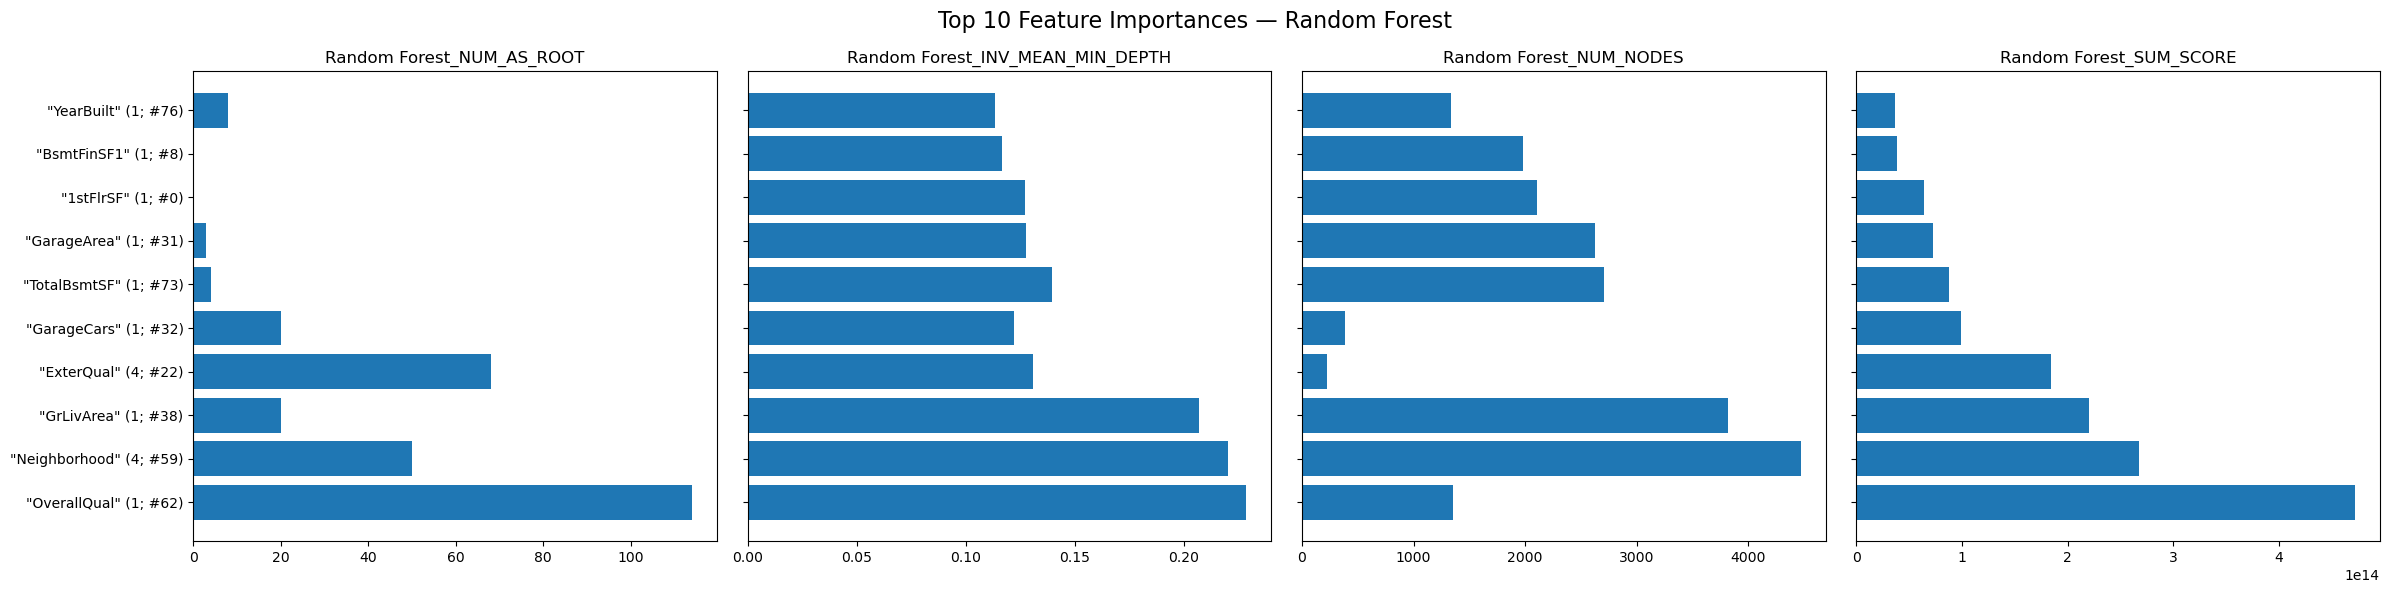

Use /tmp/tmp0ruohh4j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.143752. Found 1095 examples.
Training model...
Model trained in 0:00:03.561461
Compiling model...


[INFO 2025-09-22T16:59:22.363331655+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0ruohh4j/model/ with prefix b4e21d92a9334ee6
[INFO 2025-09-22T16:59:22.385320425+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 212ms/step

📌 Gradient Boosted Trees — Available importance types: ['NUM_AS_ROOT', 'SUM_SCORE', 'NUM_NODES', 'INV_MEAN_MIN_DEPTH']


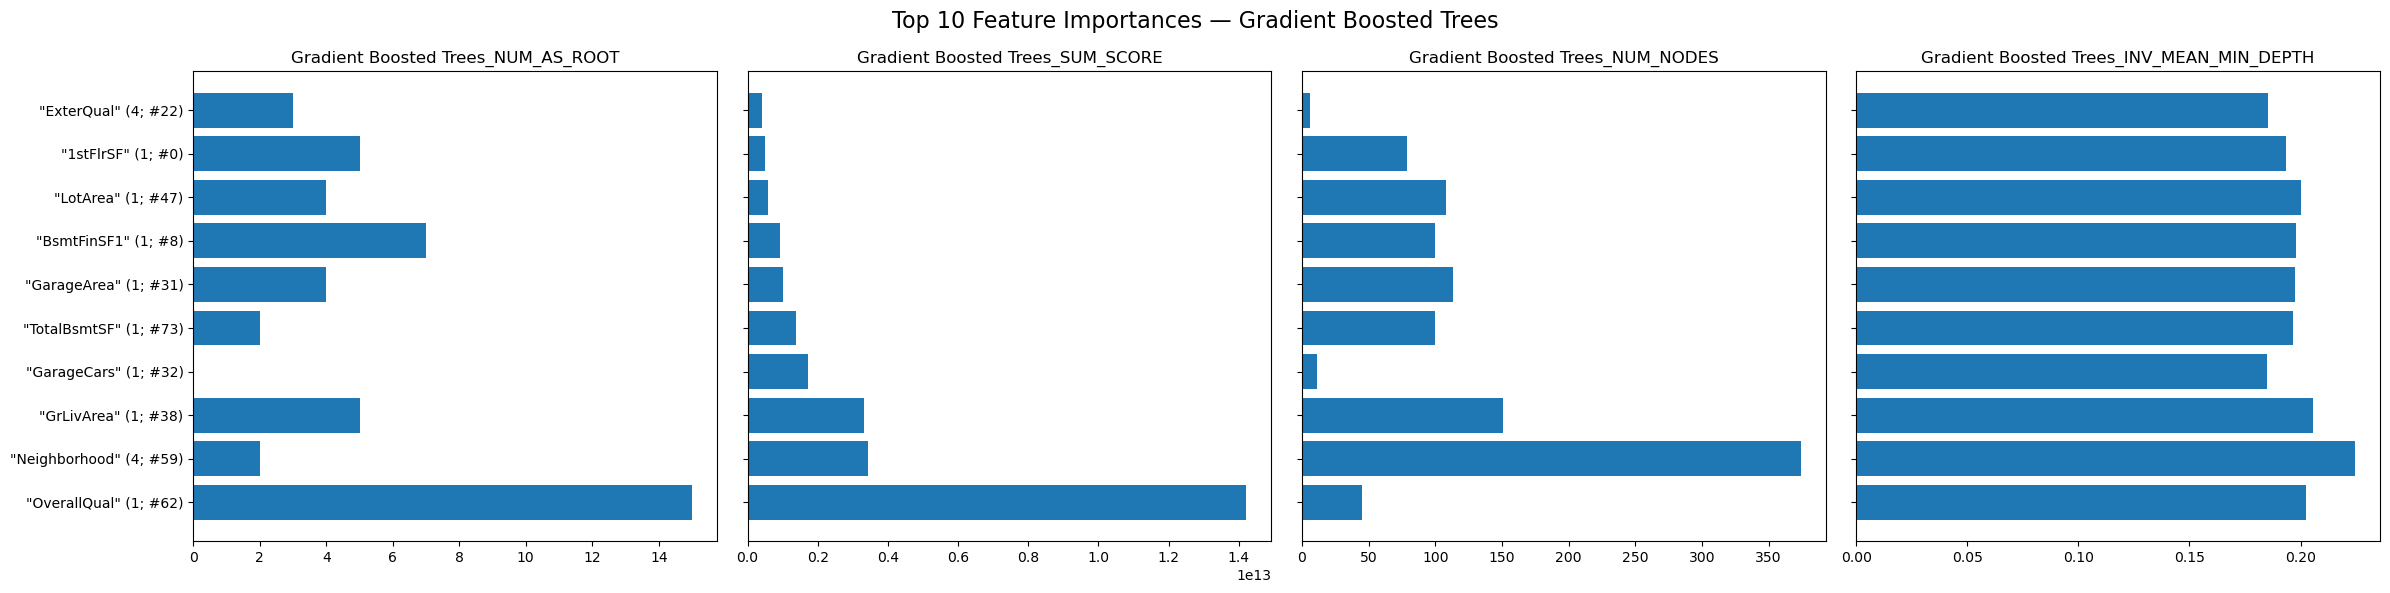

Use /tmp/tmpb_dm2rnp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.163869. Found 1095 examples.
Training model...
Model trained in 0:00:00.111026
Compiling model...


[INFO 2025-09-22T16:59:25.602995267+00:00 kernel.cc:1214] Loading model from path /tmp/tmpb_dm2rnp/model/ with prefix 255c8d9a4aa5496e
[INFO 2025-09-22T16:59:25.604445075+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 139 node(s), and 27 input feature(s).
[INFO 2025-09-22T16:59:25.604515015+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 202ms/step

📌 CART — Available importance types: ['SUM_SCORE', 'NUM_NODES', 'NUM_AS_ROOT', 'INV_MEAN_MIN_DEPTH']


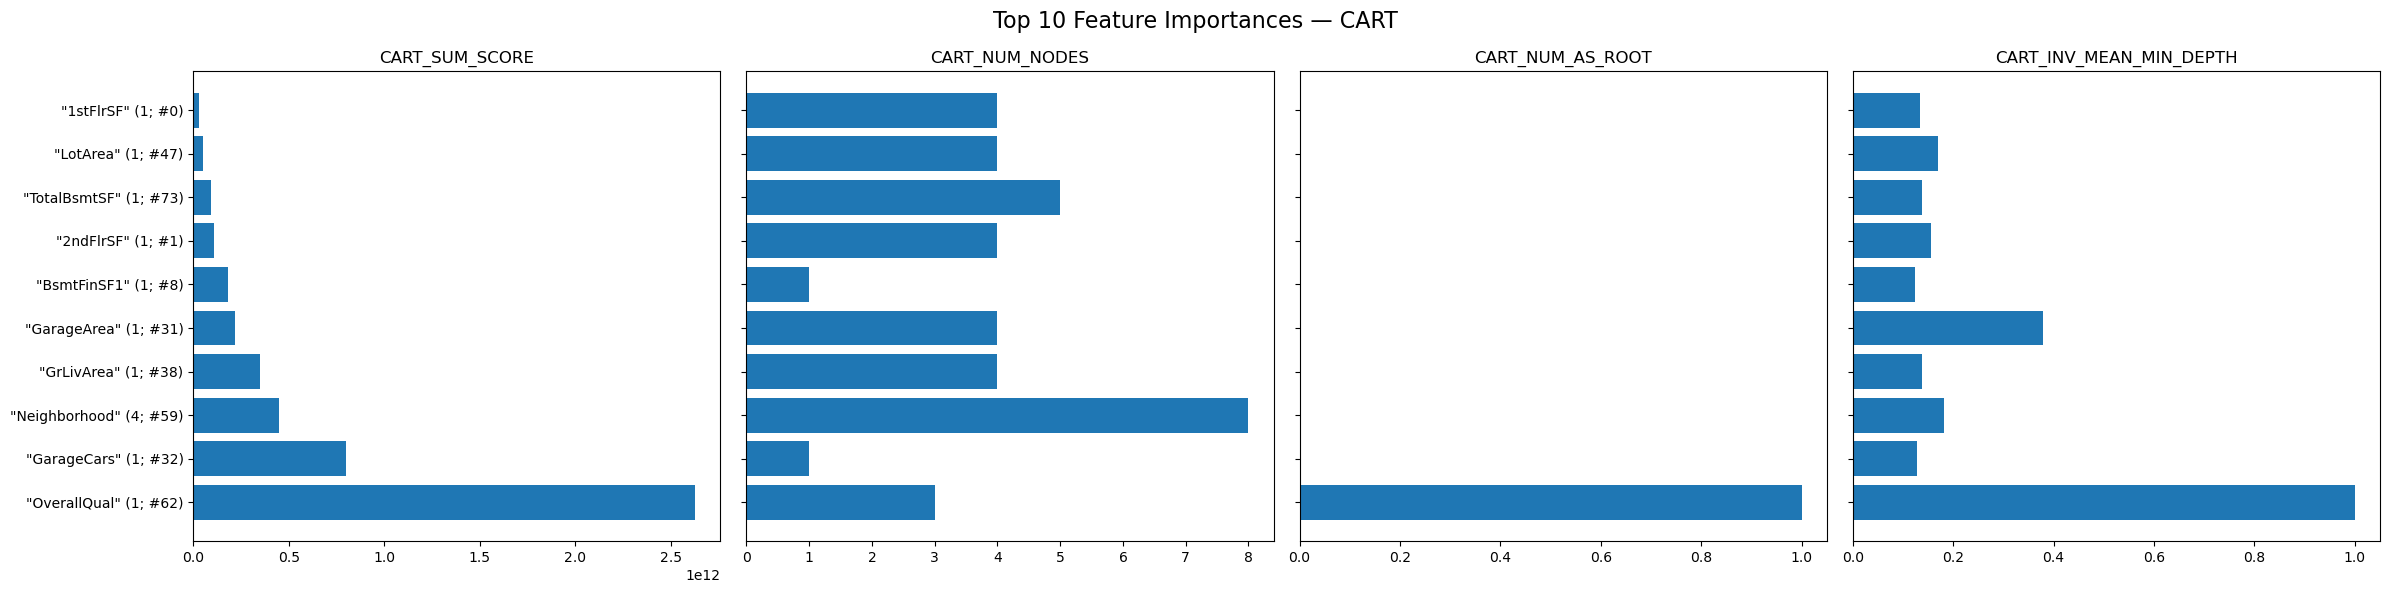

In [28]:
# =============================
# 3. Train + Evaluate Models
# =============================
results = {}
fi_tables = {}

# Random Forest
rf_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
results["Random Forest"] = evaluate_model(rf_model, valid_ds, valid_ds_pd, label, "Random Forest")
fi_tables["Random Forest"] = get_feature_importances(rf_model, "Random Forest", plot=True)

# Gradient Boosted Trees
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
results["Gradient Boosted Trees"] = evaluate_model(gbt_model, valid_ds, valid_ds_pd, label, "Gradient Boosted Trees")
fi_tables["Gradient Boosted Trees"] = get_feature_importances(gbt_model, "Gradient Boosted Trees", plot=True)

# CART
cart_model = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)
results["CART"] = evaluate_model(cart_model, valid_ds, valid_ds_pd, label, "CART")
fi_tables["CART"] = get_feature_importances(cart_model, "CART", plot=True)



In [29]:
# =============================
# 4. Combine Results
# =============================

# Metrics table (as DataFrame)
results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Results (with runtime)")
display(results_df)

# Feature importances combined into one DataFrame
fi_combined = reduce(lambda left, right: pd.merge(left, right, on="feature", how="outer"),
                     list(fi_tables.values())).fillna(0)

# Normalize each importance column to [0,1] for fair averaging
fi_norm = fi_combined.copy()
for col in fi_norm.columns[1:]:  # skip "feature"
    max_val = fi_norm[col].max()
    if max_val > 0:
        fi_norm[col] = fi_norm[col] / max_val

# Add global average importance column
fi_combined["Average_Importance"] = fi_norm.iloc[:, 1:].mean(axis=1)

# Sort by global ranking
fi_ranked = fi_combined.sort_values("Average_Importance", ascending=False).reset_index(drop=True)

print("\n📊 Combined Feature Importances (DataFrame with ranking)")
display(fi_ranked.head(20))  # show top 20

# Keep DataFrame available for further analysis
fi_ranked_df = fi_ranked



📊 Model Evaluation Results (with runtime)


,MSE,RMSE,MAE,R2,Runtime (s)
Random Forest,9.967997e+08,31572.135043,17796.304580,0.868547,4.517231
Gradient Boosted Trees,8.546866e+08,29235.022744,17516.699165,0.887288,5.706377
CART,1.970721e+09,44392.808889,29181.862778,0.740110,2.702582



📊 Combined Feature Importances (DataFrame with ranking)


,feature,Random Forest_NUM_AS_ROOT,Random Forest_INV_MEAN_MIN_DEPTH,Random Forest_NUM_NODES,Random Forest_SUM_SCORE,Gradient Boosted Trees_NUM_AS_ROOT,Gradient Boosted Trees_SUM_SCORE,Gradient Boosted Trees_NUM_NODES,Gradient Boosted Trees_INV_MEAN_MIN_DEPTH,CART_SUM_SCORE,CART_NUM_NODES,CART_NUM_AS_ROOT,CART_INV_MEAN_MIN_DEPTH,Average_Importance
0,"""OverallQual"" (1; #62)",114.0,0.228846,1358.0,4.717490e+14,15.0,1.421682e+13,45.0,0.202399,2.627427e+12,3.0,1.0,1.000000,0.808398
1,"""Neighborhood"" (4; #59)",50.0,0.220228,4468.0,2.672790e+14,2.0,3.421379e+12,374.0,0.224508,4.501864e+11,8.0,0.0,0.181347,0.557849
2,"""GrLivArea"" (1; #38)",20.0,0.207064,3819.0,2.204186e+14,5.0,3.320761e+12,151.0,0.205533,3.515458e+11,4.0,0.0,0.137795,0.421664
3,"""GarageArea"" (1; #31)",3.0,0.127618,2624.0,7.248178e+13,4.0,1.013859e+12,113.0,0.197620,2.182833e+11,4.0,0.0,0.378378,0.317226
4,"""TotalBsmtSF"" (1; #73)",4.0,0.139561,2706.0,8.780999e+13,2.0,1.366828e+12,100.0,0.196580,9.106999e+10,5.0,0.0,0.138340,0.300597
5,"""LotArea"" (1; #47)",0.0,0.110973,2399.0,2.784256e+13,4.0,5.717668e+11,108.0,0.200049,4.994398e+10,4.0,0.0,0.169903,0.271375
6,"""1stFlrSF"" (1; #0)",0.0,0.127055,2107.0,6.421307e+13,5.0,4.856364e+11,79.0,0.193620,3.206369e+10,4.0,0.0,0.133588,0.270819
7,"""2ndFlrSF"" (1; #1)",0.0,0.112803,1180.0,2.577819e+13,9.0,1.835741e+11,76.0,0.197486,1.074449e+11,4.0,0.0,0.155556,0.266990
8,"""BsmtFinSF1"" (1; #8)",0.0,0.116786,1979.0,3.836712e+13,7.0,9.292723e+11,100.0,0.197983,1.827403e+11,1.0,0.0,0.124113,0.252876
9,"""BsmtUnfSF"" (1; #15)",0.0,0.103964,1832.0,8.504182e+12,5.0,1.248877e+11,124.0,0.198426,4.605710e+09,3.0,0.0,0.119250,0.244654


# TESTING PERFORMANCE OF THE THREE MODELS USING THE TEST DATA


In [30]:
import pandas as pd

# Load test data
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop("Id")

# Convert to TFDF dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task=tfdf.keras.Task.REGRESSION
)

# Dictionary of all trained models
models = {
    "RANDOM FOREST": rf,
    "CLASSIFICATION AND REGRESSION TREE": cart_model,
    "GRADIENT BOOSTED TREE": gbt_model
    
}

# Store outputs
predictions = {}

for name, model in models.items():
    preds = model.predict(test_ds)
    output = pd.DataFrame({
        "Id": ids,
        "SalePrice": preds.squeeze()
    })
    predictions[name] = output
    print(f"\n{name} Predictions (head):")
    print(output.head())


2/2 [==============================] - 0s 25ms/step

RANDOM FOREST Predictions (head):
     Id      SalePrice
0  1461  127086.578125
1  1462  152444.578125
2  1463  180031.156250
3  1464  182889.968750
4  1465  195330.046875
2/2 [==============================] - 1s 26ms/step

CLASSIFICATION AND REGRESSION TREE Predictions (head):
     Id      SalePrice
0  1461  134047.687500
1  1462  143619.234375
2  1463  177033.343750
3  1464  177033.343750
4  1465  186163.953125
2/2 [==============================] - 1s 21ms/step

GRADIENT BOOSTED TREE Predictions (head):
     Id      SalePrice
0  1461  128173.617188
1  1462  161682.078125
2  1463  194153.000000
3  1464  194160.750000
4  1465  192193.531250


# SUBMISSION FILE

In [31]:
import pandas as pd

# Load sample submission
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

# --- Random Forest ---
rf_submission = sample_submission_df.copy()
rf_submission['SalePrice'] = rf_model.predict(test_ds).squeeze()
rf_submission.to_csv('/kaggle/working/submission.csv', index=False)

# --- Gradient Boosted Trees ---
gbt_submission = sample_submission_df.copy()
gbt_submission['SalePrice'] = gbt_model.predict(test_ds).squeeze()
gbt_submission.to_csv('/kaggle/working/submission.csv', index=False)

# --- CART ---
cart_submission = sample_submission_df.copy()
cart_submission['SalePrice'] = cart_model.predict(test_ds).squeeze()
cart_submission.to_csv('/kaggle/working/submission.csv', index=False)

# Display first few rows from each
print(" Random Forest Submission")
display(rf_submission.head())

print("\n Gradient Boosted Trees Submission")
display(gbt_submission.head())

print("\n CART Submission")
display(cart_submission.head())


2/2 [==============================] - 0s 27ms/step
 Random Forest Submission


,Id,SalePrice
0,1461,127086.578125
1,1462,152444.578125
2,1463,180031.156250
3,1464,182889.968750
4,1465,195330.046875



 Gradient Boosted Trees Submission


,Id,SalePrice
0,1461,128173.617188
1,1462,161682.078125
2,1463,194153.000000
3,1464,194160.750000
4,1465,192193.531250



 CART Submission


,Id,SalePrice
0,1461,134047.687500
1,1462,143619.234375
2,1463,177033.343750
3,1464,177033.343750
4,1465,186163.953125
